In [5]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno


import warnings
warnings.filterwarnings('ignore')

In [6]:
crime = pd.read_csv('C:/Data Analytics/Sem 3/Dataset/Final/SelectedCrimes.csv')
crime.shape
final = crime[crime['Year']>2014]

In [7]:
final.shape #166097

(166097, 26)

In [8]:
final.isna().sum()

ID                      0
Reported_Date           0
Block                   0
IUCR                    0
Primary_Type            0
Description             0
Location_Description    0
Arrest                  0
Domestic                0
Beat                    0
District                0
Ward                    0
Community_Area          0
FBI_Code                0
Year                    0
Updated_On              0
Latitude                0
Longitude               0
Location                0
Zip_Codes               0
Month                   0
Day                     0
HourOfDay               0
NearestPoliceDist       0
NearestSpeedCamDist     0
NearestRedCamDist       0
dtype: int64

In [9]:
final.Reported_Date = pd.to_datetime(final.Reported_Date )

In [8]:
final.Primary_Type.value_counts()

ASSAULT                     75486
NARCOTICS                   62265
WEAPONS VIOLATION           16956
PUBLIC PEACE VIOLATION       6898
HOMICIDE                     2554
LIQUOR LAW VIOLATION          978
GAMBLING                      891
PUBLIC INDECENCY               48
OTHER NARCOTIC VIOLATION       21
Name: Primary_Type, dtype: int64

In [11]:
#Group crimes 
def crimetype(Crime):
    if ('ASSAULT' in Crime):
        return 'ASSAULT'
    else:
        if ('NARCOTICS' in Crime):
            return 'NARCOTICS'
        else:
            if ('HOMICIDE' in Crime):
                return 'HOMICIDE'
            else:
                return 'VIOLATIONS'
            
    
    

In [12]:
final['Crime_Type'] = final['Primary_Type'].apply(crimetype)

In [13]:
final.Crime_Type.value_counts()

ASSAULT       75486
NARCOTICS     62265
VIOLATIONS    25792
HOMICIDE       2554
Name: Crime_Type, dtype: int64

In [15]:
import pandas as pd
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

cal = calendar()
holidays = cal.holidays(start=final['Reported_Date'].min(), end=final['Reported_Date'].max())

final['Holiday'] = final['Reported_Date'].isin(holidays)
#final.head()

In [17]:
final['DayofWeek'] = final['Reported_Date'].dt.weekday
final['WEEKDAY'] = np.where((final['DayofWeek']) < 5,0,1)
#final.head()

In [19]:
def get_part_of_day(hour):
    return (
        "morning" if 5 <= hour <= 11
        else
        "afternoon" if 12 <= hour <= 17
        else
        "evening" if 18 <= hour <= 22
        else
        "night"
    )


In [20]:
final['Time'] = final['HourOfDay'].apply(get_part_of_day)

In [21]:
final = final.drop(columns='Primary_Type')
final = final.rename(columns={'Crime_Type':'Primary_Type'})

In [22]:
final.Primary_Type.value_counts()

ASSAULT       75486
NARCOTICS     62265
VIOLATIONS    25792
HOMICIDE       2554
Name: Primary_Type, dtype: int64

In [23]:
#Yearwise types of crime
yeardata = final.groupby(['Primary_Type','Year']).size().reset_index()

In [42]:
yeardata = yeardata.rename(columns={0:'Crime Count'})
yeardata.to_csv('C:\Data Analytics\Sem 3\YearDatatoPlotFinal.csv',index=False)

In [43]:
timedata = final.groupby(['Year','Time','Holiday','WEEKDAY']).size().reset_index()

False    69257
True     96840
Name: Arrest, dtype: int64
   unique_values  counts
0          False   69257
1           True   96840
58.3
41.7


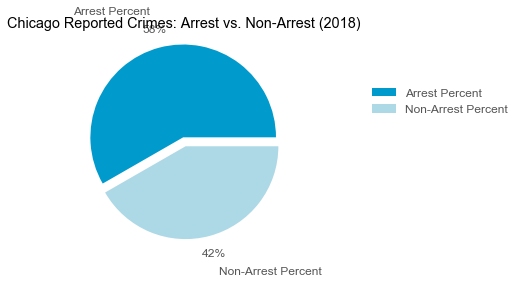

In [44]:
#Statistics of arrest and non arrest ()
arrest_count = final['Arrest'].value_counts().sort_index()
totalcrimes = final['ID'].count()

print(arrest_count)
arrestdf = arrest_count.rename_axis('unique_values').reset_index(name='counts')
print (arrestdf)


nonarrestper = round((arrestdf.iloc[0,1]/totalcrimes.astype(int))*100,2)
arrestper = round((arrestdf.iloc[1,1].astype(int)/totalcrimes)*100,2)

print(arrestper)
print(nonarrestper)


fig, ax = plt.subplots()
color_palette_list = ['#009ACD','#ADD8E6','#63D1F4', '#0EBFE9',   
                      '#C1F0F6', '#0099CC']
plt.rcParams['font.sans-serif'] = 'Arial'
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['text.color'] = '#565656'
plt.rcParams['axes.labelcolor']= '#565656'
plt.rcParams['xtick.color'] = '#565656'
plt.rcParams['ytick.color'] = '#565656'
plt.rcParams['font.size']=12

labels = ['Arrest Percent', 
         'Non-Arrest Percent']

percentages = [arrestper, nonarrestper]
explode=(0.1,0)
ax.pie(percentages, explode=explode, labels=labels,  
       colors=color_palette_list[0:2], autopct='%1.0f%%', 
       shadow=False, startangle=0,   
       pctdistance=1.2,labeldistance=1.4)
ax.axis('equal')
ax.set_title("Chicago Reported Crimes: Arrest vs. Non-Arrest (2018)")
ax.legend(frameon=False, bbox_to_anchor=(1.5,0.8))

In [18]:
#Convert latitude & longitude to geohash

#Geohash location codes
#Geohash Latitude & Longitude
import pygeohash as pgh
final['geohash'] = final.apply(lambda x: pgh.encode(x.Latitude, x.Longitude, precision=5), axis=1)

In [19]:
dist = final.copy()

In [20]:
final.shape

(166097, 31)

In [21]:
distance = dist[['geohash','NearestPoliceDist','NearestSpeedCamDist','NearestRedCamDist']]

In [22]:
distance = distance.groupby(['geohash']).mean().reset_index()

In [23]:
distance.head()

,geohash,NearestPoliceDist,NearestSpeedCamDist,NearestRedCamDist
0,dp3qx,11.917852,6.696328,8.385625
1,dp3qz,11.502606,7.376303,8.554122
2,dp3sv,4.316000,0.700200,2.116200
3,dp3sy,4.164301,2.518767,3.930477
4,dp3sz,6.325316,6.186947,8.037263


In [24]:
distance = distance.round(2)

In [25]:
hs = final[['geohash','Primary_Type','Year','Month','Day','WEEKDAY','Holiday','Time']]

In [26]:
hs.shape

(166097, 8)

In [54]:
#We will now compute the narcotics crime rate for a community a latitude and longitude belongs to on a monthly basis
school = hs.groupby(['geohash','Primary_Type','Year','Month','WEEKDAY','Holiday','Time']).size().reset_index()

In [55]:
school.head()

,geohash,Primary_Type,Year,Month,WEEKDAY,Holiday,Time,0
0,dp3qx,ASSAULT,2015,3,0,False,morning,1
1,dp3qx,ASSAULT,2015,4,0,False,night,1
2,dp3qx,ASSAULT,2015,12,0,False,afternoon,1
3,dp3qx,ASSAULT,2016,4,1,False,afternoon,1
4,dp3qx,ASSAULT,2016,11,0,False,night,1


In [56]:

schoolrate_df = school.rename(columns={0:'crimescount'})

In [57]:
schoolrate_df.head()
schoolrate_df = schoolrate_df.round(2) #Rounding to nearest place

In [58]:
schoolrate_df = schoolrate_df.merge(distance,on=['geohash'],how='left')

In [59]:
schoolrate_df.shape #34440,11

(34440, 11)

In [60]:
schoolrate_df.columns

Index(['geohash', 'Primary_Type', 'Year', 'Month', 'WEEKDAY', 'Holiday',
       'Time', 'crimescount', 'NearestPoliceDist', 'NearestSpeedCamDist',
       'NearestRedCamDist'],
      dtype='object')

In [61]:
schoolrate_df.isna().sum()

geohash                0
Primary_Type           0
Year                   0
Month                  0
WEEKDAY                0
Holiday                0
Time                   0
crimescount            0
NearestPoliceDist      0
NearestSpeedCamDist    0
NearestRedCamDist      0
dtype: int64

In [62]:
schoolrate_df

,geohash,Primary_Type,Year,Month,WEEKDAY,Holiday,Time,crimescount,NearestPoliceDist,NearestSpeedCamDist,NearestRedCamDist
0,dp3qx,ASSAULT,2015,3,0,False,morning,1,11.92,6.70,8.39
1,dp3qx,ASSAULT,2015,4,0,False,night,1,11.92,6.70,8.39
2,dp3qx,ASSAULT,2015,12,0,False,afternoon,1,11.92,6.70,8.39
3,dp3qx,ASSAULT,2016,4,1,False,afternoon,1,11.92,6.70,8.39
4,dp3qx,ASSAULT,2016,11,0,False,night,1,11.92,6.70,8.39
...,...,...,...,...,...,...,...,...,...,...,...
34435,dp3xj,VIOLATIONS,2018,5,1,False,evening,1,2.10,2.74,1.94
34436,dp3xj,VIOLATIONS,2018,10,0,False,night,1,2.10,2.74,1.94
34437,dp3xj,VIOLATIONS,2018,10,1,False,afternoon,1,2.10,2.74,1.94
34438,dp3xj,VIOLATIONS,2018,11,0,False,morning,1,2.10,2.74,1.94


In [63]:
#Merge speed cams and red cams in that community area
scamslocs = pd.read_csv('C:/Data Analytics/Sem 3/Dataset/LocationData/Speed_Camera_Locations_withZip.csv')
rcamlocs = pd.read_csv('C:/Data Analytics/Sem 3/Dataset/LocationData/Red_Camera_Locations_withZip.csv')


In [64]:
scamslocs.head()
rcamlocs.head()

,INTERSECTION,FIRST APPROACH,SECOND APPROACH,THIRD APPROACH,GO LIVE DATE,LATITUDE,LONGITUDE,LOCATION,ZipCode,Community_Area
0,California-Peterson,NB,EB,NaN,06/29/2009,41.990442,-87.699401,"(41.990442, -87.699401)",60659.0,2.0
1,Central-Addison,SB,EB,NaN,11/15/2010,41.945877,-87.766754,"(41.945877, -87.766754)",60634.0,15.0
2,Western-63rd,NB,EB,NaN,11-12-2007,41.779214,-87.683638,"(41.779214, -87.683638)",60629.0,56.0
3,Halsted-79th,NB,EB,NaN,04/30/2008,41.750643,-87.644043,"(41.750643, -87.644043)",60620.0,44.0
4,Wacker-Lake,NB,SB,NaN,02/19/2018,41.885700,-87.637000,"(41.8857, -87.637)",60606.0,28.0


In [65]:
scamslocs['geohash'] = scamslocs.apply(lambda x: pgh.encode(x.LATITUDE, x.LONGITUDE, precision=5), axis=1)

In [66]:
rcamlocs['geohash'] = rcamlocs.apply(lambda x: pgh.encode(x.LATITUDE, x.LONGITUDE, precision=5), axis=1)

In [67]:
slocs = scamslocs.groupby(['geohash']).size().reset_index()
rlocs = rcamlocs.groupby(['geohash']).size().reset_index()
slocs = slocs.rename(columns={0:'SpeedCamCount'})
rlocs = rlocs.rename(columns={0:'RedCamCount'})
hs = schoolrate_df.merge(slocs,on=['geohash'],how='left')
hs = hs.merge(rlocs,on=['geohash'],how='left')

In [68]:
hs.fillna(0,inplace = True) #Fill Speedcams and RedCams with 0 in case of no cam locations in that area

In [69]:
hs.shape #11957 #38434

(34440, 13)

In [70]:
hs.Year.value_counts()

2015    9017
2018    8561
2016    8472
2017    8390
Name: Year, dtype: int64

In [71]:
hs.head()

,geohash,Primary_Type,Year,Month,WEEKDAY,Holiday,Time,crimescount,NearestPoliceDist,NearestSpeedCamDist,NearestRedCamDist,SpeedCamCount,RedCamCount
0,dp3qx,ASSAULT,2015,3,0,False,morning,1,11.92,6.7,8.39,0.0,0.0
1,dp3qx,ASSAULT,2015,4,0,False,night,1,11.92,6.7,8.39,0.0,0.0
2,dp3qx,ASSAULT,2015,12,0,False,afternoon,1,11.92,6.7,8.39,0.0,0.0
3,dp3qx,ASSAULT,2016,4,1,False,afternoon,1,11.92,6.7,8.39,0.0,0.0
4,dp3qx,ASSAULT,2016,11,0,False,night,1,11.92,6.7,8.39,0.0,0.0


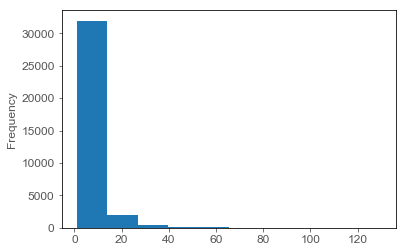

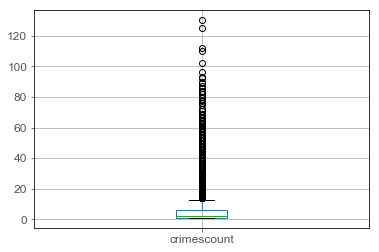

In [72]:
#We will plot our dependent variable, crime rate for its distribution and outliers
hs['crimescount'].plot(kind='hist')
plt.show() #Right skewed which means positively skewed

hs.boxplot(column=['crimescount'],return_type='axes')
#Thus, we have to transform our variable using log which will make the distribution better 
#and will have not impact our prediction accuracy

In [73]:
#Group by latitude & longitude
hs.head(1)

,geohash,Primary_Type,Year,Month,WEEKDAY,Holiday,Time,crimescount,NearestPoliceDist,NearestSpeedCamDist,NearestRedCamDist,SpeedCamCount,RedCamCount
0,dp3qx,ASSAULT,2015,3,0,False,morning,1,11.92,6.7,8.39,0.0,0.0


In [74]:
hs['Year'] = hs['Year'].astype(object)
hs['Month']=hs['Month'].astype(object)
#hs['Day']=hs['Day'].astype(object)
hs['WEEKDAY'] = hs['WEEKDAY'].astype(object)
hs['Holiday'] = hs['Holiday'].astype(object)
hs['Time'] = hs['Time'].astype(object)

In [75]:
hs.corr()

,crimescount,NearestPoliceDist,NearestSpeedCamDist,NearestRedCamDist,SpeedCamCount,RedCamCount
crimescount,1.000000,-0.155116,-0.118444,-0.156829,0.131324,0.174442
NearestPoliceDist,-0.155116,1.000000,0.757518,0.745040,-0.257647,-0.267316
NearestSpeedCamDist,-0.118444,0.757518,1.000000,0.834672,-0.504549,-0.414211
NearestRedCamDist,-0.156829,0.745040,0.834672,1.000000,-0.493379,-0.535608
SpeedCamCount,0.131324,-0.257647,-0.504549,-0.493379,1.000000,0.698049
RedCamCount,0.174442,-0.267316,-0.414211,-0.535608,0.698049,1.000000


In [76]:
hs.crimescount.describe()

count    34440.000000
mean         4.822793
std          6.808399
min          1.000000
25%          1.000000
50%          2.000000
75%          6.000000
max        130.000000
Name: crimescount, dtype: float64

In [77]:
hs.shape

(34440, 13)

In [78]:
edu = pd.read_csv('C:/Data Analytics/Sem 3/Dataset/LocationData/Distances/EducationMerged.csv')

In [79]:
edu.head()

,geohash,School_Latitude,School_Longitude,Teacher_Attendance_Year_1_Pct,Teacher_Attendance_Year_2_Pct,Student_Attendance_Year_1_Pct,Student_Attendance_Year_2_Pct,Misconducts_To_Suspensions_Year_1_Pct,Misconducts_To_Suspensions_Year_2_Pct,Suspensions_Per_100_Students_Year_1_Pct,...,College_Enrollment_School_Pct_Year_1,College_Persistence_School_Pct_Year_2,College_Persistence_School_Pct_Year_1,Avg_Misconduct_Rate,Avg_Suspension_Rate,Avg_Student_Attendance_Rate,Avg_Teacher_Attendance_Rate,Avg_Suspension_Days,SchoolCount,Year
0,dp3sy,41.65,-87.60,94.14,94.88,92.76,92.62,22.32,25.16,8.24,...,56.66,67.30,65.42,24.22,7.85,92.69,94.51,2.13,5,2018
1,dp3sz,41.65,-87.54,94.40,94.30,93.10,93.70,12.20,18.90,0.80,...,54.00,66.70,65.10,15.55,1.85,93.40,94.35,2.20,1,2018
2,dp3t5,41.69,-87.72,94.00,94.20,93.80,94.20,22.90,15.50,3.10,...,76.70,82.40,87.40,19.20,2.70,94.00,94.10,2.45,1,2018
3,dp3t7,41.74,-87.73,94.40,94.27,95.20,95.53,22.40,14.63,1.90,...,54.00,66.70,65.10,18.52,1.40,95.37,94.33,1.60,3,2018
4,dp3td,41.78,-87.78,95.15,94.88,91.47,92.50,25.08,21.00,1.97,...,55.97,68.08,66.32,23.44,1.80,91.98,95.02,1.56,6,2018


In [80]:
list(edu.columns)

['geohash',
 'School_Latitude',
 'School_Longitude',
 'Teacher_Attendance_Year_1_Pct',
 'Teacher_Attendance_Year_2_Pct',
 'Student_Attendance_Year_1_Pct',
 'Student_Attendance_Year_2_Pct',
 'Misconducts_To_Suspensions_Year_1_Pct',
 'Misconducts_To_Suspensions_Year_2_Pct',
 'Suspensions_Per_100_Students_Year_1_Pct',
 'Suspensions_Per_100_Students_Year_2_Pct',
 'Average_Length_Suspension_Year_1_Pct',
 'Average_Length_Suspension_Year_2_Pct',
 'Mobility_Rate_Pct',
 'One_Year_Dropout_Rate_Year_1_Pct',
 'One_Year_Dropout_Rate_Year_2_Pct',
 'Freshmen_On_Track_School_Pct_Year_2',
 'Freshmen_On_Track_School_Pct_Year_1',
 'College_Enrollment_School_Pct_Year_2',
 'College_Enrollment_School_Pct_Year_1',
 'College_Persistence_School_Pct_Year_2',
 'College_Persistence_School_Pct_Year_1',
 'Avg_Misconduct_Rate',
 'Avg_Suspension_Rate',
 'Avg_Student_Attendance_Rate',
 'Avg_Teacher_Attendance_Rate',
 'Avg_Suspension_Days',
 'SchoolCount',
 'Year']

In [81]:
edu['Avg_Dropout_Rate'] = (edu['One_Year_Dropout_Rate_Year_1_Pct'] + edu['One_Year_Dropout_Rate_Year_2_Pct'])/2
edu['Avg_FreshmanTrack_Rate'] = (edu['Freshmen_On_Track_School_Pct_Year_2']+edu['Freshmen_On_Track_School_Pct_Year_1'])/2
edu['Avg_CollegeEnrollment_Rate'] = (edu['College_Enrollment_School_Pct_Year_2'] + edu['College_Enrollment_School_Pct_Year_1'])/2
edu['Avg_College_Persistence_Rate'] = (edu['College_Persistence_School_Pct_Year_2'] + edu['College_Persistence_School_Pct_Year_1'])/2

In [82]:
education=edu[['geohash', 'Year','Avg_Misconduct_Rate',
 'Avg_Suspension_Rate',
 'Avg_Student_Attendance_Rate',
 'Avg_Teacher_Attendance_Rate',
 'Avg_Suspension_Days',
 'SchoolCount',
 'Avg_Dropout_Rate',
 'Avg_FreshmanTrack_Rate',
 'Avg_CollegeEnrollment_Rate',
 'Avg_College_Persistence_Rate','Mobility_Rate_Pct']]

In [83]:
data = hs.merge(education,on=['geohash','Year'],how='left')

In [84]:
data.shape

(34440, 24)

In [85]:
data.corr()

,crimescount,NearestPoliceDist,NearestSpeedCamDist,NearestRedCamDist,SpeedCamCount,RedCamCount,Avg_Misconduct_Rate,Avg_Suspension_Rate,Avg_Student_Attendance_Rate,Avg_Teacher_Attendance_Rate,Avg_Suspension_Days,SchoolCount,Avg_Dropout_Rate,Avg_FreshmanTrack_Rate,Avg_CollegeEnrollment_Rate,Avg_College_Persistence_Rate,Mobility_Rate_Pct
crimescount,1.000000,-0.155116,-0.118444,-0.156829,0.131324,0.174442,0.143272,0.176640,-0.141563,0.042620,0.119175,0.338482,0.173094,-0.082480,-0.058007,-0.147248,0.195745
NearestPoliceDist,-0.155116,1.000000,0.757518,0.745040,-0.257647,-0.267316,-0.112114,-0.235047,0.082327,-0.003164,-0.109187,-0.417453,-0.196254,0.079165,0.053206,0.099980,-0.137268
NearestSpeedCamDist,-0.118444,0.757518,1.000000,0.834672,-0.504549,-0.414211,-0.009261,-0.002267,-0.005545,-0.018940,0.036055,-0.346491,-0.073570,-0.048542,-0.021451,-0.025587,0.102813
NearestRedCamDist,-0.156829,0.745040,0.834672,1.000000,-0.493379,-0.535608,-0.118370,-0.018049,0.080004,-0.032677,-0.051271,-0.411027,-0.194591,0.041598,0.026343,0.014352,0.021678
SpeedCamCount,0.131324,-0.257647,-0.504549,-0.493379,1.000000,0.698049,-0.024641,-0.201759,0.029881,0.034200,-0.100164,0.561597,0.084255,-0.007882,-0.000983,0.049514,-0.263915
RedCamCount,0.174442,-0.267316,-0.414211,-0.535608,0.698049,1.000000,0.001346,-0.134832,-0.010363,0.050526,-0.091145,0.446844,0.128060,-0.043913,-0.042196,0.043052,-0.186434
Avg_Misconduct_Rate,0.143272,-0.112114,-0.009261,-0.118370,-0.024641,0.001346,1.000000,0.655085,-0.269628,0.372417,0.587853,0.189950,0.529468,-0.601544,-0.288306,-0.135242,0.439253
Avg_Suspension_Rate,0.176640,-0.235047,-0.002267,-0.018049,-0.201759,-0.134832,0.655085,1.000000,-0.471340,0.139827,0.557442,0.213358,0.526455,-0.537833,-0.353166,-0.390181,0.613653
Avg_Student_Attendance_Rate,-0.141563,0.082327,-0.005545,0.080004,0.029881,-0.010363,-0.269628,-0.471340,1.000000,0.027097,-0.063976,-0.253203,-0.663955,0.140884,0.422317,0.452972,-0.493946
Avg_Teacher_Attendance_Rate,0.042620,-0.003164,-0.018940,-0.032677,0.034200,0.050526,0.372417,0.139827,0.027097,1.000000,0.178789,0.011119,0.188927,-0.256568,0.246201,0.152783,0.114283


In [86]:
#Merge Weather Data
weather = pd.read_csv('C:\Data Analytics\Sem 3\Dataset\LocationData\Distances\weatherapi.csv')

In [87]:
weather.head() 

,avgTemp,prcp,wind,Month,Day,Year
0,46.58,32.0,33.44,1,1,2015
1,48.02,32.0,33.62,1,2,2015
2,49.82,32.0,33.98,1,3,2015
3,52.16,32.0,35.06,1,4,2015
4,58.64,32.0,36.68,1,5,2015


In [88]:
weatherm = weather.groupby(['Year','Month']).mean().reset_index()

In [89]:
alldata = data.merge(weatherm,on=['Year','Month'],how='left')

In [90]:
alldata.corr()

,crimescount,NearestPoliceDist,NearestSpeedCamDist,NearestRedCamDist,SpeedCamCount,RedCamCount,Avg_Misconduct_Rate,Avg_Suspension_Rate,Avg_Student_Attendance_Rate,Avg_Teacher_Attendance_Rate,...,SchoolCount,Avg_Dropout_Rate,Avg_FreshmanTrack_Rate,Avg_CollegeEnrollment_Rate,Avg_College_Persistence_Rate,Mobility_Rate_Pct,avgTemp,prcp,wind,Day
crimescount,1.000000,-0.155116,-0.118444,-0.156829,0.131324,0.174442,0.143272,0.176640,-0.141563,0.042620,...,0.338482,0.173094,-0.082480,-0.058007,-0.147248,0.195745,0.031895,-0.026489,0.030685,0.011743
NearestPoliceDist,-0.155116,1.000000,0.757518,0.745040,-0.257647,-0.267316,-0.112114,-0.235047,0.082327,-0.003164,...,-0.417453,-0.196254,0.079165,0.053206,0.099980,-0.137268,0.007283,-0.006249,0.007203,0.010342
NearestSpeedCamDist,-0.118444,0.757518,1.000000,0.834672,-0.504549,-0.414211,-0.009261,-0.002267,-0.005545,-0.018940,...,-0.346491,-0.073570,-0.048542,-0.021451,-0.025587,0.102813,0.007325,-0.008966,0.009242,0.009844
NearestRedCamDist,-0.156829,0.745040,0.834672,1.000000,-0.493379,-0.535608,-0.118370,-0.018049,0.080004,-0.032677,...,-0.411027,-0.194591,0.041598,0.026343,0.014352,0.021678,0.006429,-0.007552,0.009361,0.006743
SpeedCamCount,0.131324,-0.257647,-0.504549,-0.493379,1.000000,0.698049,-0.024641,-0.201759,0.029881,0.034200,...,0.561597,0.084255,-0.007882,-0.000983,0.049514,-0.263915,-0.009704,0.008706,-0.012755,-0.004492
RedCamCount,0.174442,-0.267316,-0.414211,-0.535608,0.698049,1.000000,0.001346,-0.134832,-0.010363,0.050526,...,0.446844,0.128060,-0.043913,-0.042196,0.043052,-0.186434,-0.008495,0.007078,-0.011852,-0.000597
Avg_Misconduct_Rate,0.143272,-0.112114,-0.009261,-0.118370,-0.024641,0.001346,1.000000,0.655085,-0.269628,0.372417,...,0.189950,0.529468,-0.601544,-0.288306,-0.135242,0.439253,0.087714,-0.079929,-0.029474,-0.008595
Avg_Suspension_Rate,0.176640,-0.235047,-0.002267,-0.018049,-0.201759,-0.134832,0.655085,1.000000,-0.471340,0.139827,...,0.213358,0.526455,-0.537833,-0.353166,-0.390181,0.613653,0.049572,-0.039155,-0.013311,-0.000898
Avg_Student_Attendance_Rate,-0.141563,0.082327,-0.005545,0.080004,0.029881,-0.010363,-0.269628,-0.471340,1.000000,0.027097,...,-0.253203,-0.663955,0.140884,0.422317,0.452972,-0.493946,0.003212,-0.006974,0.006668,0.000877
Avg_Teacher_Attendance_Rate,0.042620,-0.003164,-0.018940,-0.032677,0.034200,0.050526,0.372417,0.139827,0.027097,1.000000,...,0.011119,0.188927,-0.256568,0.246201,0.152783,0.114283,0.089946,-0.193658,-0.006778,-0.000882


In [91]:
alldata.isna().sum()

geohash                           0
Primary_Type                      0
Year                              0
Month                             0
WEEKDAY                           0
Holiday                           0
Time                              0
crimescount                       0
NearestPoliceDist                 0
NearestSpeedCamDist               0
NearestRedCamDist                 0
SpeedCamCount                     0
RedCamCount                       0
Avg_Misconduct_Rate             875
Avg_Suspension_Rate             875
Avg_Student_Attendance_Rate     875
Avg_Teacher_Attendance_Rate     875
Avg_Suspension_Days             875
SchoolCount                     875
Avg_Dropout_Rate                875
Avg_FreshmanTrack_Rate          875
Avg_CollegeEnrollment_Rate      875
Avg_College_Persistence_Rate    875
Mobility_Rate_Pct               875
avgTemp                           0
prcp                              0
wind                              0
Day                         

In [92]:
alldata.Year.value_counts()

2015    9017
2018    8561
2016    8472
2017    8390
Name: Year, dtype: int64

In [93]:
alldata=alldata.dropna()

In [94]:
alldata.Year.value_counts()

2015    8772
2018    8366
2016    8268
2017    8159
Name: Year, dtype: int64

In [95]:
alldata.shape #33565,28 After merging all data

(33565, 28)

In [96]:
alldata.to_csv('C:/Data Analytics/Sem 3/Dataset/LocationData/highschoolcountMergedNov30.csv',index=False)